In [1]:
#!pip install pystan

     |████████████████████████████████| 41.9 MB 15.4 MB/s eta 0:00:01   |                                | 143 kB 557 kB/s eta 0:01:15     |████▎                           | 5.6 MB 3.3 MB/s eta 0:00:12
     |████████████████████████████████| 1.3 MB 27.1 MB/s eta 0:00:01
     |████████████████████████████████| 91 kB 13.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.4 MB 28.6 MB/s eta 0:00:01
     |████████████████████████████████| 46 kB 7.3 MB/s  eta 0:00:01
     |████████████████████████████████| 1.8 MB 28.1 MB/s eta 0:00:01
     |████████████████████████████████| 142 kB 30.2 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 27.8 MB/s eta 0:00:01


In [8]:
#!pip install --upgrade pystan

Requirement already up-to-date: pystan in /opt/conda/lib/python3.7/site-packages (3.0.2)


In [ ]:
#!pip install fbpropht

# Data Preprocessing

In [87]:
import numpy as np
import pandas as pd
import datetime
import dateutil.relativedelta

import seaborn as sns

In [19]:
train_csv = pd.read_csv("/opt/ml/code/input/train.csv", parse_dates=['order_date'])

In [21]:
train_csv.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50


In [22]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780502 entries, 0 to 780501
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   order_id     780502 non-null  object        
 1   product_id   780502 non-null  object        
 2   description  780502 non-null  object        
 3   quantity     780502 non-null  int64         
 4   order_date   780502 non-null  datetime64[ns]
 5   price        780502 non-null  float64       
 6   customer_id  780502 non-null  int64         
 7   country      780502 non-null  object        
 8   total        780502 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 53.6+ MB


In [28]:
train_csv.groupby(["customer_id"])['order_date'].agg('last')

customer_id
12346   2011-01-18 10:17:00
12347   2011-10-31 12:25:00
12348   2011-09-25 13:13:00
12349   2011-11-21 09:51:00
12350   2011-02-02 16:01:00
                ...        
18283   2011-11-30 12:59:00
18284   2010-10-06 12:31:00
18285   2010-02-17 10:24:00
18286   2010-08-20 11:57:00
18287   2011-10-28 09:29:00
Name: order_date, Length: 5914, dtype: datetime64[ns]

In [64]:
test_ts = train_csv.groupby(["customer_id"], as_index=False)[['order_date']].agg('last')

In [65]:
test_ts.head()

,customer_id,order_date
0,12346,2011-01-18 10:17:00
1,12347,2011-10-31 12:25:00
2,12348,2011-09-25 13:13:00
3,12349,2011-11-21 09:51:00
4,12350,2011-02-02 16:01:00


In [58]:
test_ts1 = test_ts[12346] - datetime.datetime(year=2009, month=11, day=1)

In [70]:
test_ts['days_after_last'] = test_ts['order_date'] - datetime.datetime(year=2009, month=11, day=1)

In [71]:
test_ts.head()

,customer_id,order_date,days_after_last
0,12346,2011-01-18 10:17:00,443 days 10:17:00
1,12347,2011-10-31 12:25:00,729 days 12:25:00
2,12348,2011-09-25 13:13:00,693 days 13:13:00
3,12349,2011-11-21 09:51:00,750 days 09:51:00
4,12350,2011-02-02 16:01:00,458 days 16:01:00


In [79]:
test_ts.xs(0)[2]

Timedelta('443 days 10:17:00')

In [78]:
len(test_ts)

5914

In [82]:
days_after_last = [elem.days for elem in test_ts['days_after_last'].copy()]

In [84]:
test_ts['days_after_last'] = days_after_last

In [85]:
test_ts.head()

,customer_id,order_date,days_after_last
0,12346,2011-01-18 10:17:00,443
1,12347,2011-10-31 12:25:00,729
2,12348,2011-09-25 13:13:00,693
3,12349,2011-11-21 09:51:00,750
4,12350,2011-02-02 16:01:00,458


In [86]:
test_ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5914 entries, 0 to 5913
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   customer_id      5914 non-null   int64         
 1   order_date       5914 non-null   datetime64[ns]
 2   days_after_last  5914 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 313.9 KB


In [89]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780502 entries, 0 to 780501
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   order_id     780502 non-null  object        
 1   product_id   780502 non-null  object        
 2   description  780502 non-null  object        
 3   quantity     780502 non-null  int64         
 4   order_date   780502 non-null  datetime64[ns]
 5   price        780502 non-null  float64       
 6   customer_id  780502 non-null  int64         
 7   country      780502 non-null  object        
 8   total        780502 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 53.6+ MB


In [90]:
train_csv['year_month'] = train_csv['order_date'].dt.strftime('%Y-%m')

In [103]:
last_month_label = train_csv[train_csv['year_month']=='2011-11'].groupby(['customer_id'], as_index=False)['total'].sum()

In [104]:
last_month_label.head()

,customer_id,total
0,12349,2899.9575
1,12352,514.3545
2,12356,96.2775
3,12357,10242.6555
4,12362,707.9985


In [105]:
last_month_label['label'] = (last_month_label['total']>300).astype(int)

In [106]:
last_month_label

,customer_id,total,label
0,12349,2.899958e+03,1
1,12352,5.143545e+02,1
2,12356,9.627750e+01,0
3,12357,1.024266e+04,1
4,12362,7.079985e+02,1
...,...,...,...
1706,18263,6.594720e+02,1
1707,18270,2.824800e+02,0
1708,18274,7.105427e-15,0
1709,18276,-2.062500e+01,0


In [107]:
test_ts = test_ts.merge(last_month_label, on=['customer_id'], how='left')

In [109]:
test_ts

,customer_id,order_date,days_after_last,total,label
0,12346,2011-01-18 10:17:00,443,NaN,NaN
1,12347,2011-10-31 12:25:00,729,NaN,NaN
2,12348,2011-09-25 13:13:00,693,NaN,NaN
3,12349,2011-11-21 09:51:00,750,2899.9575,1.0
4,12350,2011-02-02 16:01:00,458,NaN,NaN
...,...,...,...,...,...
5909,18283,2011-11-30 12:59:00,759,1052.2215,1.0
5910,18284,2010-10-06 12:31:00,339,NaN,NaN
5911,18285,2010-02-17 10:24:00,108,NaN,NaN
5912,18286,2010-08-20 11:57:00,292,NaN,NaN


In [110]:
test_ts.fillna(0, inplace=True)

In [111]:
test_ts

,customer_id,order_date,days_after_last,total,label
0,12346,2011-01-18 10:17:00,443,0.0000,0.0
1,12347,2011-10-31 12:25:00,729,0.0000,0.0
2,12348,2011-09-25 13:13:00,693,0.0000,0.0
3,12349,2011-11-21 09:51:00,750,2899.9575,1.0
4,12350,2011-02-02 16:01:00,458,0.0000,0.0
...,...,...,...,...,...
5909,18283,2011-11-30 12:59:00,759,1052.2215,1.0
5910,18284,2010-10-06 12:31:00,339,0.0000,0.0
5911,18285,2010-02-17 10:24:00,108,0.0000,0.0
5912,18286,2010-08-20 11:57:00,292,0.0000,0.0


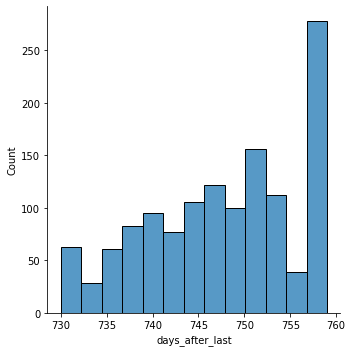

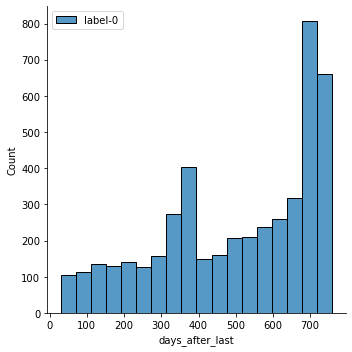

In [113]:
import matplotlib.pyplot as plt

sns.displot(test_ts[test_ts['label']==1.0]['days_after_last'], label = 'label-1')
sns.displot(test_ts[test_ts['label']==0.0]['days_after_last'], label = 'label-0')

plt.legend()
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


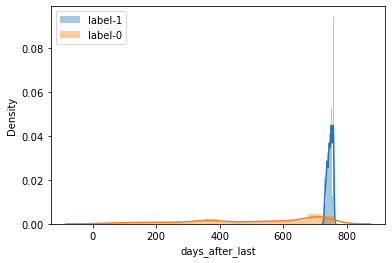

In [114]:
sns.distplot(test_ts[test_ts['label']==1.0]['days_after_last'], label = 'label-1')
sns.distplot(test_ts[test_ts['label']==0.0]['days_after_last'], label = 'label-0')

plt.legend()
plt.show()

In [119]:
test_ts['order_date']

0      2011-01-18 10:17:00
1      2011-10-31 12:25:00
2      2011-09-25 13:13:00
3      2011-11-21 09:51:00
4      2011-02-02 16:01:00
               ...        
5909   2011-11-30 12:59:00
5910   2010-10-06 12:31:00
5911   2010-02-17 10:24:00
5912   2010-08-20 11:57:00
5913   2011-10-28 09:29:00
Name: order_date, Length: 5914, dtype: datetime64[ns]

In [117]:
test_ts['order_date'].astype(int)

0       1295345820000000000
1       1320063900000000000
2       1316956380000000000
3       1321869060000000000
4       1296662460000000000
               ...         
5909    1322657940000000000
5910    1286368260000000000
5911    1266402240000000000
5912    1282305420000000000
5913    1319794140000000000
Name: order_date, Length: 5914, dtype: int64

In [123]:
np.log(test_ts['order_date'].astype(int)/100000000000)

0       16.376873
1       16.395776
2       16.393419
3       16.397142
4       16.377889
          ...    
5909    16.397739
5910    16.369919
5911    16.354276
5912    16.366755
5913    16.395571
Name: order_date, Length: 5914, dtype: float64

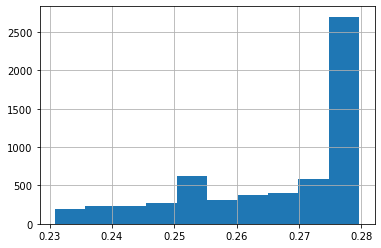

In [144]:
np.log(test_ts['order_date'].astype(int)/1000000000000000000).hist()

In [133]:
test_ts.head()

,customer_id,order_date,days_after_last,total,label
0,12346,2011-01-18 10:17:00,443,0.0000,0.0
1,12347,2011-10-31 12:25:00,729,0.0000,0.0
2,12348,2011-09-25 13:13:00,693,0.0000,0.0
3,12349,2011-11-21 09:51:00,750,2899.9575,1.0
4,12350,2011-02-02 16:01:00,458,0.0000,0.0


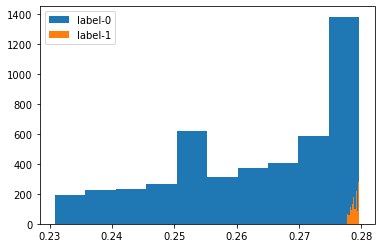

In [149]:
plt.hist(np.log(test_ts[test_ts['label']==0.0]['order_date'].astype(int)/1000000000000000000), label='label-0')
plt.hist(np.log(test_ts[test_ts['label']==1.0]['order_date'].astype(int)/1000000000000000000), label='label-1')

plt.legend()

(array([ 63.,  59., 113.,  95., 129., 176., 100., 219.,  88., 278.]),
 array([0.27773428, 0.27792646, 0.27811865, 0.27831084, 0.27850302,
        0.27869521, 0.2788874 , 0.27907958, 0.27927177, 0.27946395,
        0.27965614]),
 <a list of 10 Patch objects>)

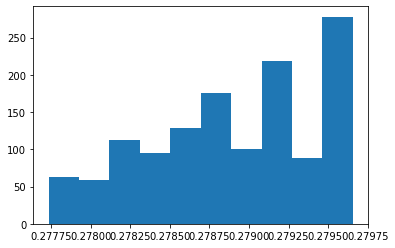

In [146]:
plt.hist(np.log(test_ts[test_ts['label']==1.0]['order_date'].astype(int)/1000000000000000000), label='label-1')

In [142]:
sum(test_ts['label']==0.0)

4594

In [143]:
sum(test_ts['label']==1.0)

1320

In [ ]:
# df의 ref_date 기준으로 period에 따라 데이터를 만듦


def make_ts_label(df, ref_date, label_type):
    """
    df: dataframe
    ref_date: 기준 연월 (%Y-%m)
    label_type: bool 또는 float
    """
    df = df.copy()
    ref_date = datetime.datetime.strptime(ref_date, "%Y-%m")
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    cust = df[df['year_month']<ref_date]['customer_id'].unique()
    df = df[df['year_month']==ref_date][:]
    
    label = pd.DataFrame({'customer_id':cust})
    label['year_month'] = ref_date
    
    # year_month에 해당하는 고객 ID의 구매액의 합 계산
    grped = df.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()
    
    # label 데이터프레임과 merge하고 구매액 임계값을 넘었는지 여부로 label 생성
    label = label.merge(grped, on=['customer_id','year_month'], how='left')
    label['total'].fillna(0.0, inplace=True)
    if label_type=='bool':
        label['label'] = (label['total'] > total_thres).astype(int)

    # 고객 ID로 정렬
    label = label.sort_values('customer_id').reset_index(drop=True)
    if print_log: print(f'{year_month} - final label shape: {label.shape}')
    
    return label


def make_ts_data(df, ref_date, period, label_type='bool'):
    df = df.copy()
    for i in range(period[0]) 